In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix

import math
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime
from pdpbox import pdp
from plotnine import *

In [2]:
import time
import os
import ast
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np

import itertools
import re
import seaborn as sns

import nltk
from nltk.corpus import stopwords

In [3]:
#import matplotlib.pyplot as plt
#import numpy as np
#from sklearn import metrics
#from sklearn.datasets import fetch_openml
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.impute import SimpleImputer
#from sklearn.inspection import permutation_importance
#from sklearn.compose import ColumnTransformer
#from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import OneHotEncoder

In [4]:
#from fastai.imports import *
import fastai

In [5]:
from fastai import *

In [6]:
#! pip3 install fastai

In [7]:
from sklearn.inspection import permutation_importance

In [8]:
from sklearn.metrics import confusion_matrix, f1_score

In [9]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [56]:
# %load structured.py
#from .imports import *

from sklearn_pandas import DataFrameMapper
#from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import _forest as forest
from sklearn.tree import export_graphviz

def set_plot_sizes(sml, med, big):
    plt.rc('font', size=sml)          # controls default text sizes
    plt.rc('axes', titlesize=sml)     # fontsize of the axes title
    plt.rc('axes', labelsize=med)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('legend', fontsize=sml)    # legend fontsize
    plt.rc('figure', titlesize=big)  # fontsize of the figure title

def parallel_trees(m, fn, n_jobs=8):
        return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

def combine_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
              seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.
    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.
    Returns:
    --------
    return value: A random sample of n rows of df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    >>> get_sample(df, 2)
       col1 col2
    1     2    b
    2     3    a
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def add_datepart(df, fldnames, drop=True, time=False, errors="raise"):	
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string or list of strings that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    >>>df2 = pd.DataFrame({'start_date' : pd.to_datetime(['3/11/2000','3/13/2000','3/15/2000']),
                            'end_date':pd.to_datetime(['3/17/2000','3/18/2000','4/1/2000'],infer_datetime_format=True)})
    >>>df2
        start_date	end_date    
    0	2000-03-11	2000-03-17
    1	2000-03-13	2000-03-18
    2	2000-03-15	2000-04-01
    >>>add_datepart(df2,['start_date','end_date'])
    >>>df2
    	start_Year	start_Month	start_Week	start_Day	start_Dayofweek	start_Dayofyear	start_Is_month_end	start_Is_month_start	start_Is_quarter_end	start_Is_quarter_start	start_Is_year_end	start_Is_year_start	start_Elapsed	end_Year	end_Month	end_Week	end_Day	end_Dayofweek	end_Dayofyear	end_Is_month_end	end_Is_month_start	end_Is_quarter_end	end_Is_quarter_start	end_Is_year_end	end_Is_year_start	end_Elapsed
    0	2000	    3	        10	        11	        5	            71	            False	            False	                False	                False	                False	            False	            952732800	    2000	    3	        11	        17	    4	            77	            False	            False	            False	            False	                False	        False	            953251200
    1	2000	    3	        11	        13	        0	            73	            False	            False	                False	                False               	False           	False           	952905600     	2000       	3	        11      	18  	5           	78          	False	            False           	False           	False               	False          	False           	953337600
    2	2000	    3	        11	        15	        2           	75          	False           	False               	False               	False               	False               False           	953078400      	2000    	4          	13      	1   	5           	92          	False           	True            	False           	True                	False          	False           	954547200
    """
    if isinstance(fldnames,str): 
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)

def is_date(x): return np.issubdtype(x.dtype, np.datetime64)

def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category {a : 1, b : 2}
    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)
           col1 col2
        0     1    b
        1     2    a
        2     3    a
    now the type of col is category {a : 1, b : 2}
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

def get_nn_mappers(df, cat_vars, contin_vars):
    # Replace nulls with 0 for continuous, "" for categorical.
    for v in contin_vars: df[v] = df[v].fillna(df[v].max()+100,)
    for v in cat_vars: df[v].fillna('#NA#', inplace=True)

    # list of tuples, containing variable and instance of a transformer for that variable
    # for categoricals, use LabelEncoder to map to integers. For continuous, standardize
    cat_maps = [(o, LabelEncoder()) for o in cat_vars]
    contin_maps = [([o], StandardScaler()) for o in contin_vars]

In [57]:
#PATH = "data/"

#df_raw = pd.read_feather('tmp/articles_politics-raw')
#pd.set_option("display.max_columns",100)

In [58]:
df_raw =  pd.read_csv("../../FINAL/data/dataFACEBOOK.csv", thousands=',')

In [59]:
df_raw.columns

Index(['url', 'date', 'author', 'Title', 'Noimages', 'Publication', 'length',
       'difficulty', 'uniq_wds', 'char_count', 'avg_word', 'perc_uniq',
       'sentence length', 'stopwords', 'mistakes', '#links', 'numbers',
       'first_person', 'mtld', 'msttr', 'hdd', 'caps_body', 'anger',
       'positivity', 'joy', 'disgust', 'surprise', 'trust', 'anticipation',
       'sadness', 'negative', 'fear', 'density', 'sad', 'happy', 'inspired',
       'dont_care', 'annoyed', 'amused', 'afraid', 'polarity',
       'negativity_vader', 'neutrality_vader', 'positivity_vader',
       'subjectivity', 'No Celebs', 'adjectives', 'cadence', 'No Animals',
       'No Crime', 'No Sensual', 'Entertainment', 'diversity',
       'Total Interactions', 'Likes', 'Comments', 'Shares', 'Love', 'Wow',
       'Haha', 'Sad', 'Angry', 'Care', 'Message', 'Link', 'Overperforming',
       'Afinnity', 'Strong_subjectivity', 'Weak_subjectivity', 'Valence',
       'Arousal', 'Dominance', 'Anger_intensity', 'Joy_intensit

In [60]:
df_raw = df_raw.rename(columns={'difficulty': 'Difficulty','title_polarity': 'Title polarity', 
                          'length':'Length', 'anger':'Anger' , 'positivity': 'Positivity',
       'joy':'Joy', 'disgust':'Disgust', 'surprise':'Surprise', 'trust':'Trust', 'anticipation':'Anticipation', 
                                'sadness':'Sadness',
      'fear':'Fear', 'numbers':'Numbers', 'polarity': 'Polarity', 'lexical richness': 'Lexical richness',
       'cosine': 'Cosine Similarity', 'sad':'Sad_', 'happy': 'Happy', 'inspired': 'Inspired', 
                                'dont_care':'I do not care', 'annoyed':'Annoyed', 'amused':'Amused',
       'afraid':'Afraid', 'sentence length':'Sentence length', 'mistakes':'Mistakes', 'adjectives':'Adjectives',
       'diversity':'Diversity', 'balance':'Balance',  'Strong_subjectivity':'Strong subjectivity',
       'Weak_subjectivity':'Weak subjectivity', 
       'Anger_intensity': 'Anger intensity', 'Joy_intensity':'Joy intensity', 
                                'Sadness_intensity':'Sadness intensity',
       'Fear_intensity':'Fear intensity', 'caps_body':'Capitals in article'})

In [61]:
df_raw = df_raw[[ 'Length', 'Difficulty', 
             'Anger', 'Positivity', 'Joy', 'Disgust', 'Surprise', 'Trust', 'Anticipation', 'Sadness', 
             'Fear', 'density', 'Sad_', 'Happy', 'Inspired', 'I do not care', 'Annoyed', 'Amused', 'Afraid', 
             'Polarity', 'No Celebs', 'Adjectives', 'No Animals', 'No Crime', 'No Sensual', 'Entertainment', 
             'Diversity', 'Total Interactions', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad', 
             'Angry', 'Care', 'Overperforming', 'Strong subjectivity', 'Valence', 'Arousal', 'Dominance', 
             'Anger intensity', 'Joy intensity', 'Sadness intensity', 'Fear intensity', '#title_words', 
  'Title cursing', 'Subjectivity Message', 
             'Subjectivity Title', 'Caps Title'] ].copy()

In [62]:
#df_raw.drop(['profanity', 'similarity', 'quotes','noun_to_verb_ratio', 'named_entity_person' ,'named_entity_money' ], axis=1, inplace=True)

In [63]:
df_raw.head()

Length  Difficulty      Anger  Positivity       Joy   Disgust  Surprise  \
0   361.0        47.0  10.222222    6.666667  3.111111  4.888889  2.222222   
1  4761.0        54.0   5.170388   20.387779  9.224442  4.465335  2.761457   
2  5232.0        57.0   4.463800   13.881328  3.157322  5.008165  4.082744   
3  1607.0        45.0   7.185629   10.179641  3.592814  2.994012  4.311377   
4   457.0        62.0   1.181102    7.874016  1.968504  1.181102  0.787402   

       Trust  Anticipation    Sadness  ...  Dominance  Anger intensity  \
0   4.444444      4.000000  11.111111  ...   0.502066         0.231532   
1  17.978848     13.572268   9.224442  ...   0.529479         0.078494   
2   8.219924      7.131192   5.661404  ...   0.525597         0.129745   
3   8.383234      5.149701   5.149701  ...   0.564048         0.181884   
4   3.149606      0.787402   0.787402  ...   0.559984         0.057471   

   Joy intensity  Sadness intensity  Fear intensity  #title_words  \
0       0.092617           0.318660        0.358106          11.0   
1       0.187974           0.201905        0.197372          12.0   
2       0.121286           0.159272        0.272068           9.0   
3       0.138551           0.167094        0.286551          11.0   
4       0.333529           0.042294        0.072588          10.0   

   Title cursing  Subjectivity Message   Subjectivity Title  Caps Title  
0              0                   0.0                  0.0           0  
1              0                   0.0  0.06666666666666667           0  
2              0                 0.125                  0.0           0  
3              0                   0.2                  0.0           0  
4              0                   0.0                0.125           0  

[5 rows x 51 columns]

In [64]:
df_raw.shape

(73036, 51)

In [65]:
data_good = df_raw[df_raw['Likes'] >2102] #'Total Interactions']>15000  ['Shares'] >1986
data_good.shape
data_good['engagement'] = 1

In [66]:
data_bad = df_raw[df_raw['Likes'] <7] 
data_bad.shape
data_bad['engagement'] = 0

In [67]:
pdList = [data_bad, data_good]  # List of your dataframes
df_raw= pd.concat(pdList)

In [68]:
df_raw.drop(['Total Interactions',  'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Overperforming',  'Likes',
               ], axis=1, inplace=True)

In [69]:
df_raw = df_raw.sample(frac=1).reset_index(drop=True)

In [70]:
df_trn, y_trn, nas = proc_df(df_raw, 'engagement')

In [71]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 2000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [72]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [73]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13239013569067692, 0.31622776601683794, 0.9824728519718041, 0.9, 0.891026862259478]


In [74]:
# Lets Try a RF classifier selecting manually the parameters

m = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features= 0.5, max_leaf_nodes=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0,
            warm_start=False)

m.fit(X_train, y_train)

print_score(m)

[0.18259157633715084, 0.31464265445104544, 0.9666603162507145, 0.901, 0.8944560868736903]


This is the first prediction from the first tree for the first row

In [75]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 139 ms, sys: 0 ns, total: 139 ms
Wall time: 139 ms


(0.75, 0.4330127018922193)

In [76]:
#!pip3 install concurrent.futures

In [77]:
#executor = concurrent.futures.ThreadPoolExecutor(maxworkers=2)

In [78]:
#def get_preds(t): return t.predict(X_valid)
#%time preds = np.stack(parallel_trees(m, get_preds))
#np.mean(preds[:,0]), np.std(preds[:,0])

We can see that different trees are giving different estimates. In order to see how prediction confidence varies, we can add this into our dataset.

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know how it's making predictions. The most important way to see this is with feature importance.

In [79]:
fi = rf_feat_importance(m, df_trn); fi[:10]

cols       imp
0                 Length  0.277348
35          #title_words  0.141850
30             Dominance  0.108876
1             Difficulty  0.093210
20             No Celebs  0.077614
26             Diversity  0.029379
8           Anticipation  0.025179
29               Arousal  0.019972
37  Subjectivity Message  0.015674
27   Strong subjectivity  0.015475

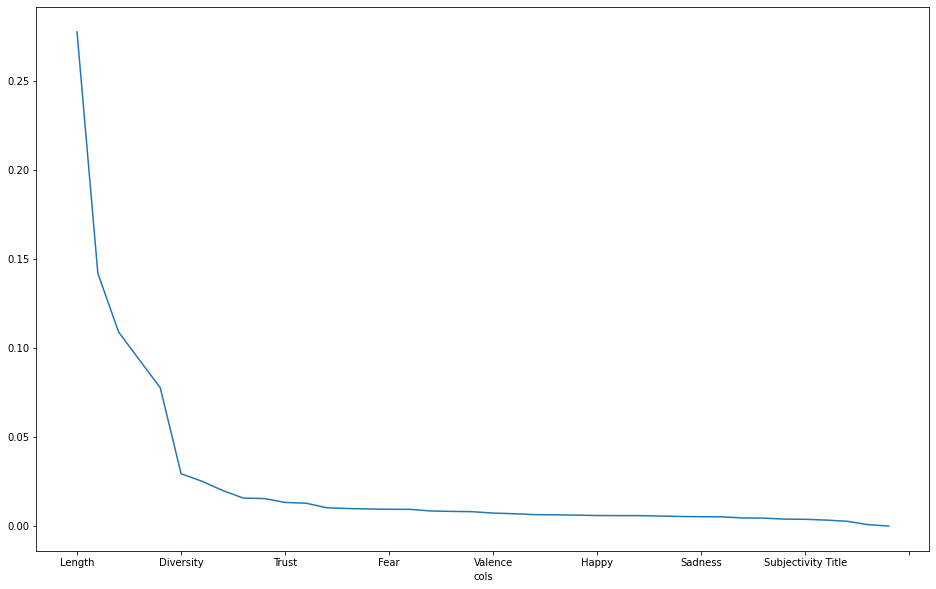

In [80]:
fi.plot('cols', 'imp', figsize=(16,10), legend=False)

In [81]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [82]:
to_keep = fi[fi.imp>0.001].cols; len(to_keep)

38

In [83]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [84]:
m = RandomForestClassifier(n_estimators=1000, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11711916349107401, 0.30983866769659335, 0.9862831015431511, 0.904, 0.8975042865307677]


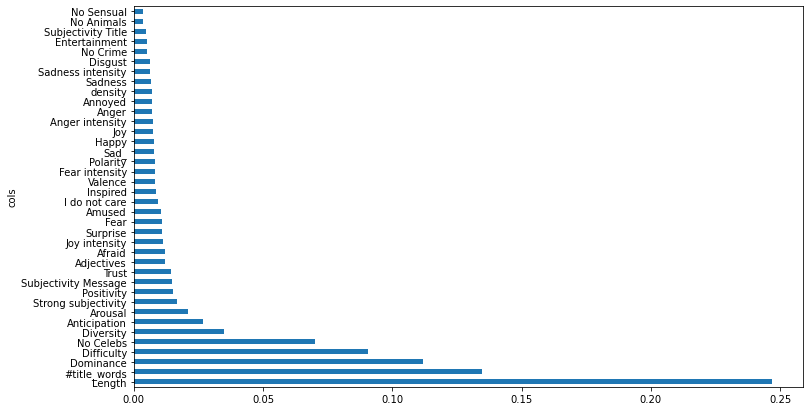

In [86]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi)

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [87]:
from scipy.cluster import hierarchy as hc
from scipy import linalg, optimize
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

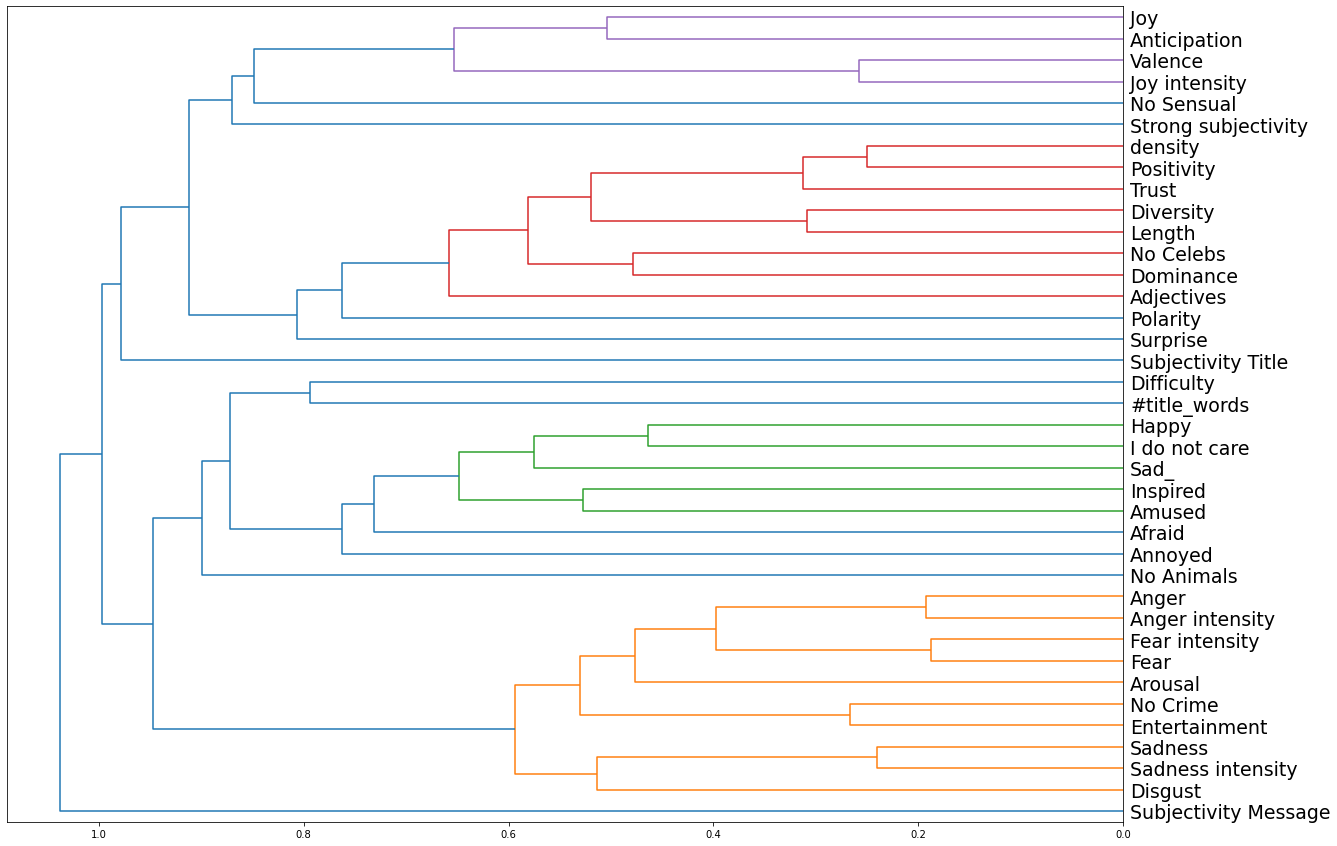

In [88]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(20,15))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=19)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [89]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [90]:
get_oob(df_keep)

0.8896932749095066

Now we try removing each variable one at a time.

In [91]:
df_keep.columns

Index(['Length', '#title_words', 'Dominance', 'Difficulty', 'No Celebs',
       'Diversity', 'Anticipation', 'Arousal', 'Subjectivity Message',
       'Strong subjectivity', 'Trust', 'Positivity', 'Afraid', 'Adjectives',
       'Joy intensity', 'Fear', 'Surprise', 'Fear intensity', 'Amused',
       'I do not care', 'Valence', 'Inspired', 'Anger intensity', 'Polarity',
       'Sad_', 'Happy', 'Joy', 'Sadness intensity', 'Anger', 'density',
       'Sadness', 'Annoyed', 'Entertainment', 'Disgust', 'No Crime',
       'Subjectivity Title', 'No Animals', 'No Sensual'],
      dtype='object')

In [93]:
for c in ('Length', '#title_words', 'Dominance', 'Difficulty', 'No Celebs',
       'Diversity', 'Anticipation', 'Arousal', 'Subjectivity Message',
       'Strong subjectivity', 'Trust', 'Positivity', 'Afraid', 'Adjectives',
       'Joy intensity', 'Fear', 'Surprise', 'Fear intensity', 'Amused',
       'I do not care', 'Valence', 'Inspired', 'Anger intensity', 'Polarity',
       'Sad_', 'Happy', 'Joy', 'Sadness intensity', 'Anger', 'density',
       'Sadness', 'Annoyed', 'Entertainment', 'Disgust', 'No Crime',
       'Subjectivity Title', 'No Animals', 'No Sensual'
       ):
    print(c, get_oob(df_keep.drop(c, axis=1)))

Length 0.8759763764526577
#title_words 0.8561630786816536
Dominance 0.8875976376452658
Difficulty 0.8885502000381025
No Celebs 0.8914078872166127
Diversity 0.8883596875595352
Anticipation 0.8858830253381597
Arousal 0.8925509620880168
Subjectivity Message 0.886073537816727
Strong subjectivity 0.8900742998666412
Trust 0.8896932749095066
Positivity 0.8889312249952371
Afraid 0.8944560868736903
Adjectives 0.8887407125166699
Joy intensity 0.8912173747380453
Fear 0.8915983996951801
Surprise 0.8858830253381597
Fear intensity 0.8895027624309392
Amused 0.891026862259478
I do not care 0.8914078872166127
Valence 0.8906458373023433
Inspired 0.8914078872166127
Anger intensity 0.8906458373023433
Polarity 0.8915983996951801
Sad_ 0.8870261002095637
Happy 0.8879786626024004
Joy 0.8902648123452086
Sadness intensity 0.8915983996951801
Anger 0.8919794246523147
density 0.8875976376452658
Sadness 0.8919794246523147
Annoyed 0.8885502000381025
Entertainment 0.8919794246523147
Disgust 0.8898837873880739
No Crim

It looks like we can try one from each group for removal. Let's see what that does.

In [99]:
to_drop = [  
            'Afraid', 'Fear intensity','Sadness',   'Entertainment','Subjectivity Title', 'Joy',
       'Strong subjectivity', 'Joy intensity',  'Surprise',
       
      'No Sensual', 'No Animals', 
    
 
       'I do not care',  'Sad_', 'Adjectives',
       'Amused',  'Disgust', 'Annoyed',
       'Happy',  'Trust', 'density',
        'Anger', 'Sadness intensity',
        'Anger intensity',
       ]
get_oob(df_keep.drop(to_drop, axis=1))


0.8921699371308821

Nothing really dramatic! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [100]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [111]:
df_keep.columns

Index(['Length', '#title_words', 'Dominance', 'Difficulty', 'No Celebs',
       'Diversity', 'Anticipation', 'Arousal', 'Subjectivity Message',
       'Positivity', 'Fear', 'Valence', 'Inspired', 'Polarity', 'No Crime'],
      dtype='object')

In [101]:
#np.save('tmp/pol_cols.npy', np.array(df_keep.columns))

In [102]:
#keep_cols = np.load('tmp/pol_cols.npy', allow_pickle=True)
#df_keep = df_trn[keep_cols]

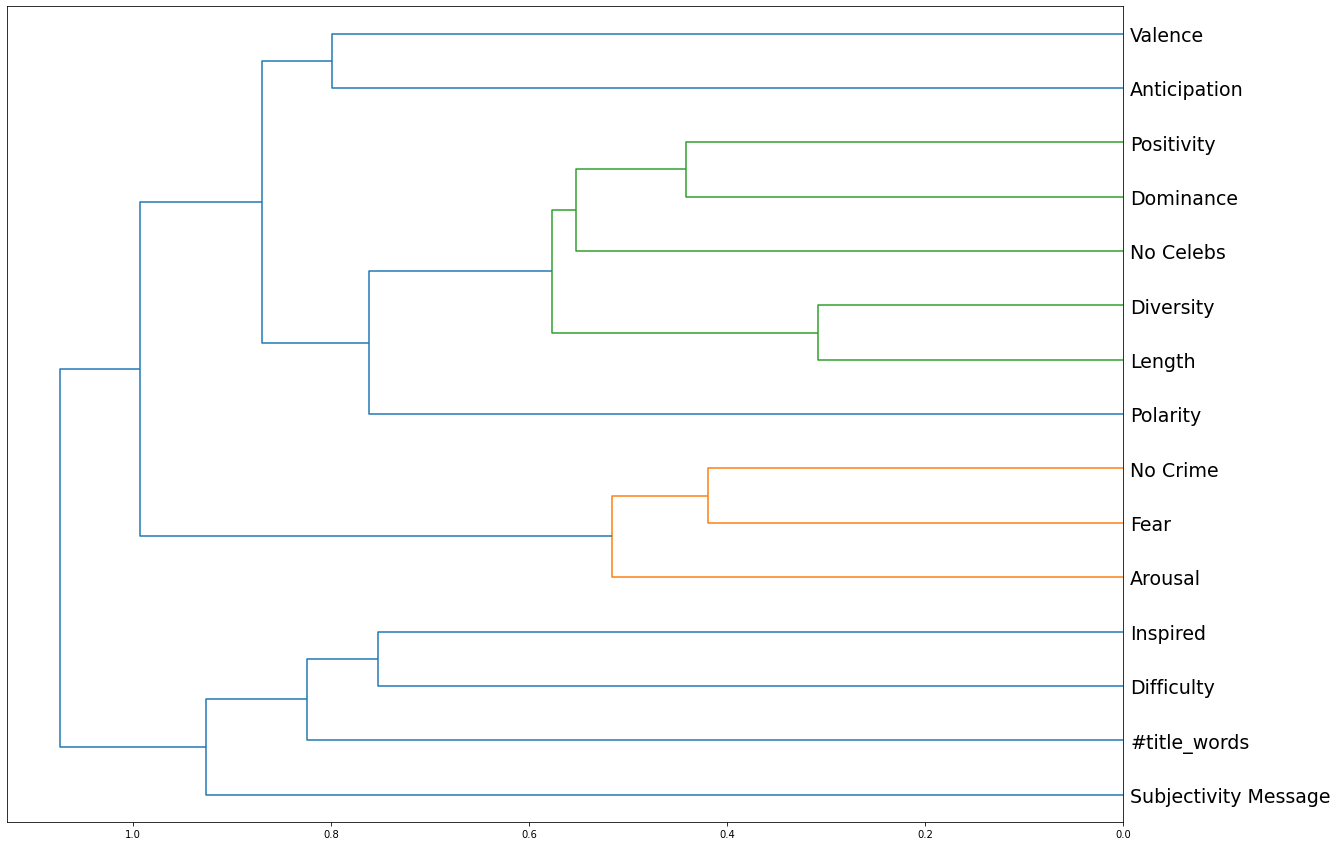

In [103]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(20,15))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=19)
plt.show()

And let's see how this model looks with 10000 estimators.

In [104]:
#reset_rf_samples()

In [105]:
m = RandomForestClassifier(n_estimators=10000, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1549340901786486, 0.31859064644147983, 0.9759954277005144, 0.8985, 0.895408649266527]


In [106]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1579782728489027, 0.3154362059117501, 0.9750428653076777, 0.9005, 0.8923604496094494]


# Partial dependence

In [107]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(max_features=0.6, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1)

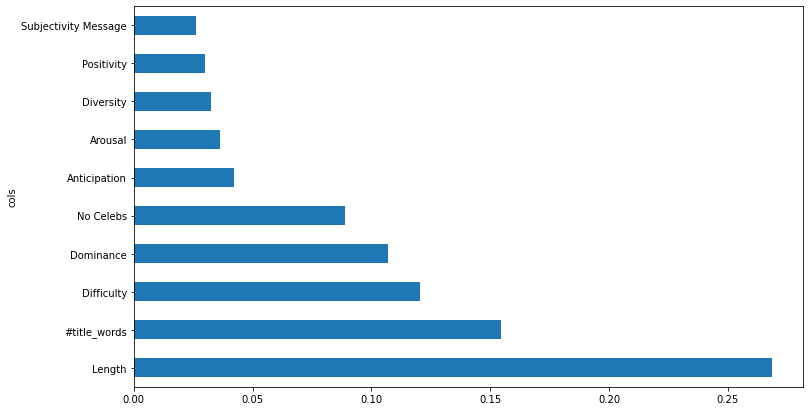

In [108]:
plot_fi(rf_feat_importance(m, df_keep)[:10])

KeyError: 'lexical_diversity'

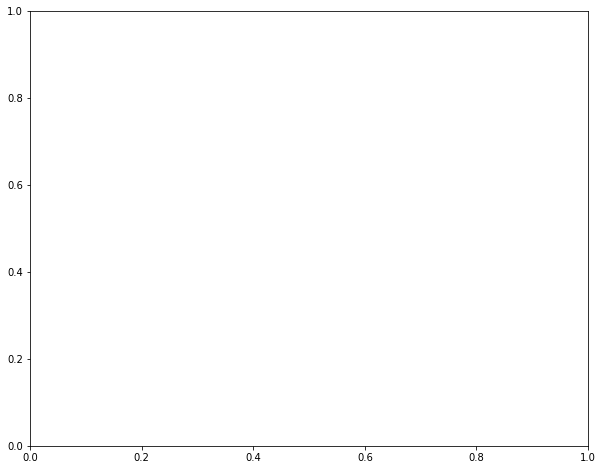

In [109]:
df_raw.plot('lexical_diversity', 'second_person','scatter', alpha=0.01, figsize=(10,8));

In [110]:
x_all = get_sample(df_raw, 5000)

In [243]:
x_all['fake'].head()

0    1
5    0
6    0
7    0
8    1
Name: fake, dtype: int64

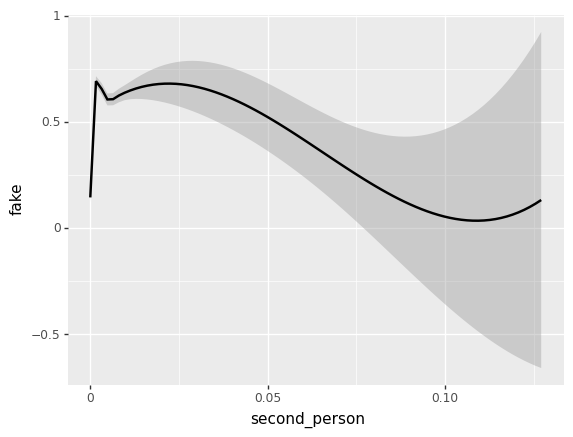

<ggplot: (8789970970717)>

In [244]:
ggplot(x_all, aes('second_person', 'fake')) + stat_smooth(se=True, method='loess') #auto den mas leei kati omws
#theloume na doume ti kanei to random forest

In [106]:
x = get_sample(X_train, 5000)

In [107]:
def plot_pdp(feat_name, clusters=None):
#feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature=feat_name, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                   cluster=clusters is not None, n_cluster_centers=clusters)

In [108]:
## An ola ta alla values meinoun stathera kai allaxei mono to Followed By pws allazei to apotelesma sta claps

In [110]:
plot_pdp('body_length')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe95cfed910>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe95cfc8d50>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe95cfeda50>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe9301b8950>})

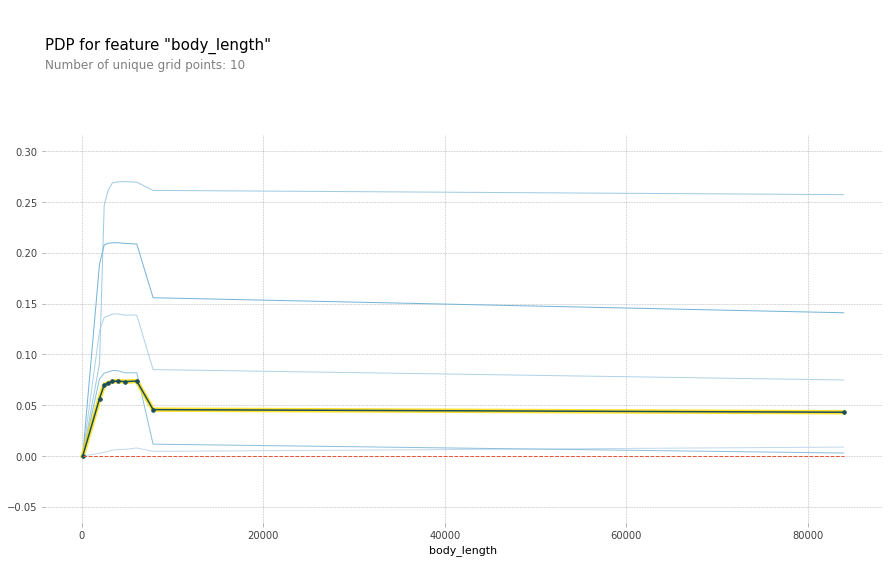

In [111]:
#Five most common insights we see above
plot_pdp('body_length', clusters=5)

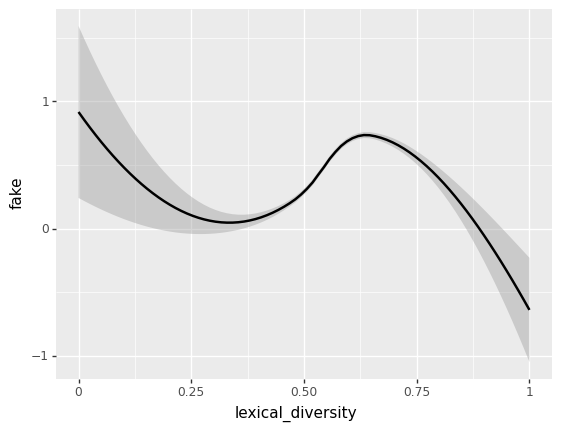

<ggplot: (8789996597373)>

In [113]:
ggplot(x_all, aes('lexical_diversity', 'fake')) + stat_smooth(se=True, method='loess') #auto den mas leei kati omws
#theloume na doume ti kanei to random forest

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe949f63fd0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe949ff0c10>})

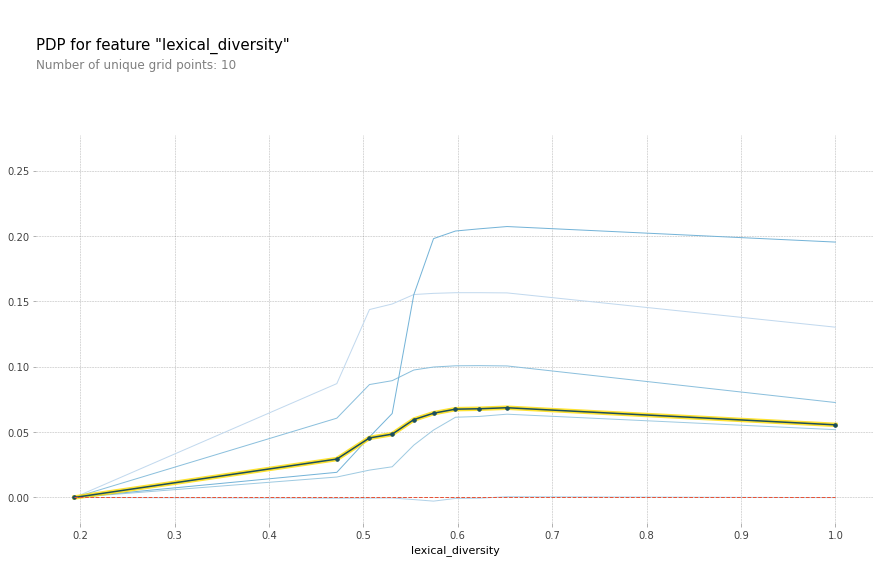

In [114]:
plot_pdp('lexical_diversity', clusters=5)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f76254aa080>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f762514f2b0>})

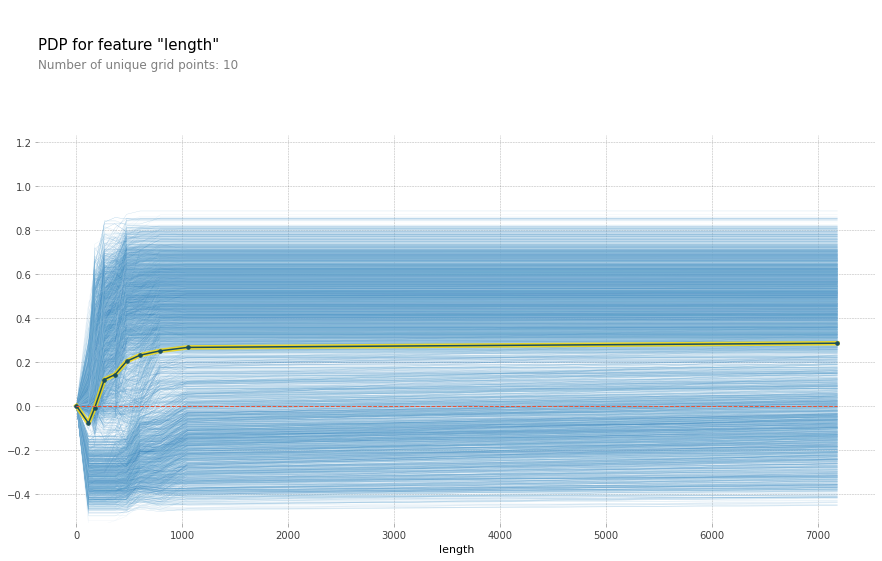

In [92]:
plot_pdp('length')

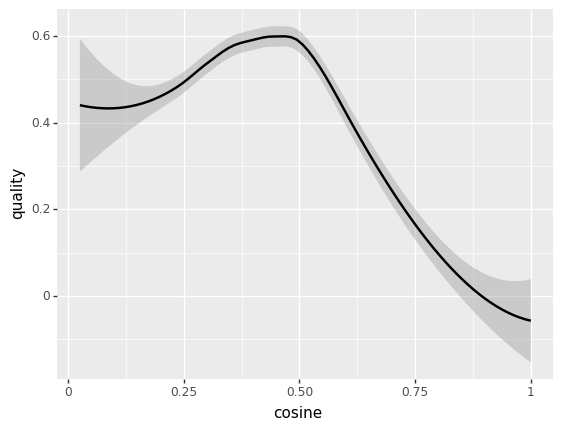

<ggplot: (8782286971235)>

In [148]:
ggplot(x_all, aes('cosine', 'quality')) + stat_smooth(se=True, method='loess')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc918ca978>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc918095c0>})

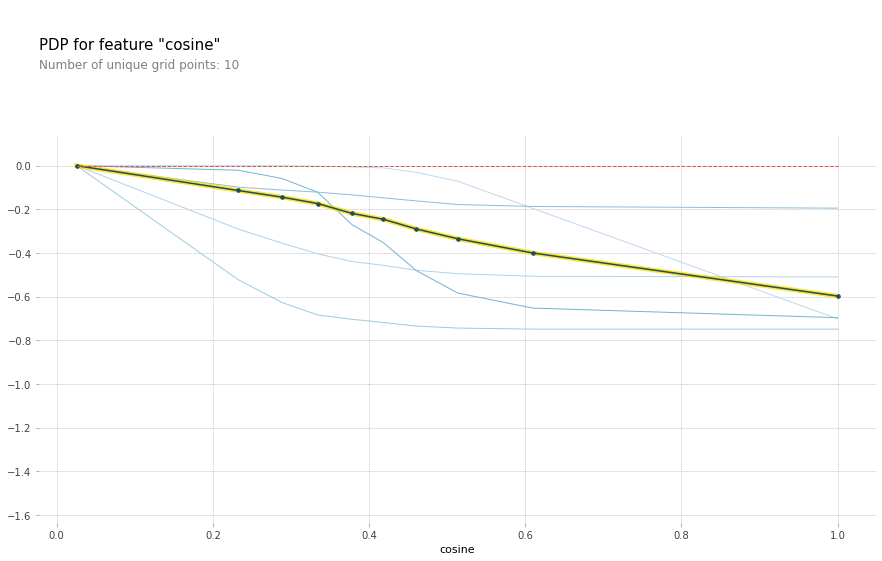

In [149]:
plot_pdp('cosine', clusters=5)

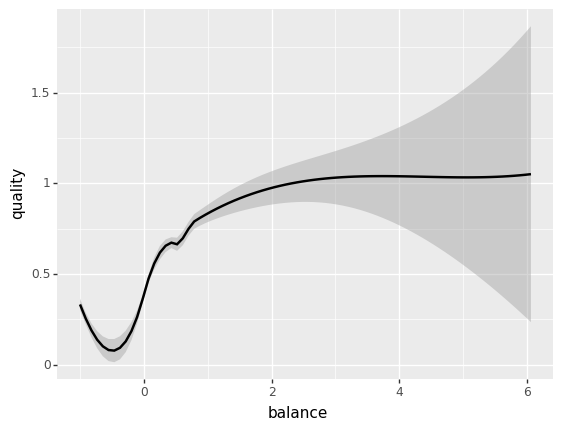

<ggplot: (8782277787582)>

In [157]:
ggplot(x_all, aes('balance', 'quality')) + stat_smooth(se=True, method='loess')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc9171be48>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc9170c278>})

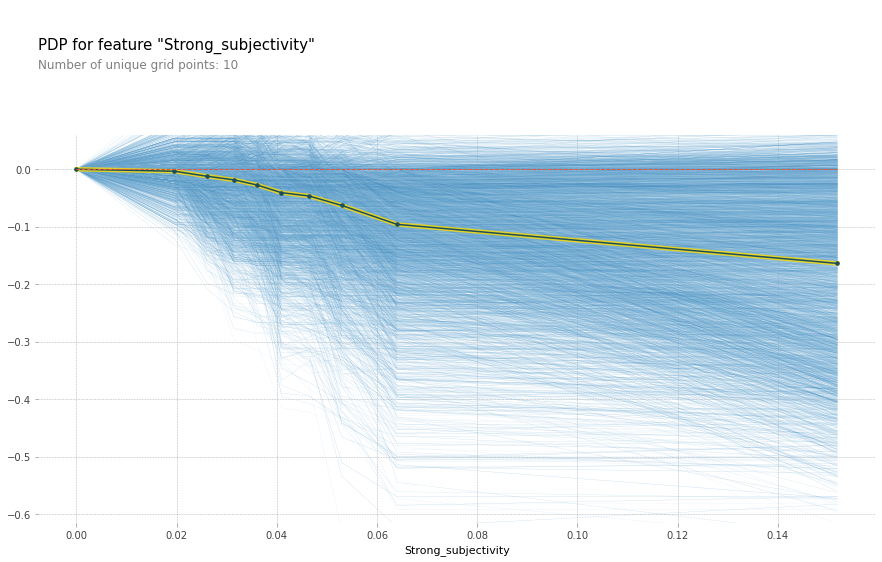

In [153]:
plot_pdp('Strong_subjectivity')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc8a78bc88>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc8a44f898>})

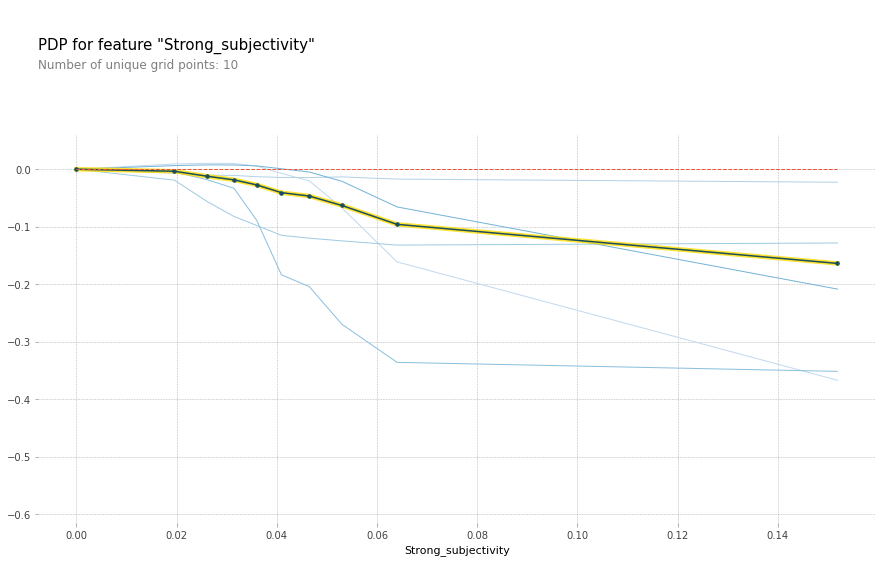

In [154]:
plot_pdp('Strong_subjectivity', clusters=5)

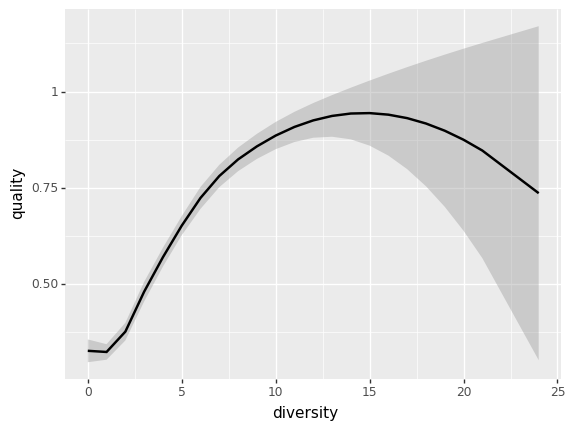

<ggplot: (8782279576482)>

In [155]:
ggplot(x_all, aes('diversity', 'quality')) + stat_smooth(se=True, method='loess')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc8e07b080>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc8df4c828>})

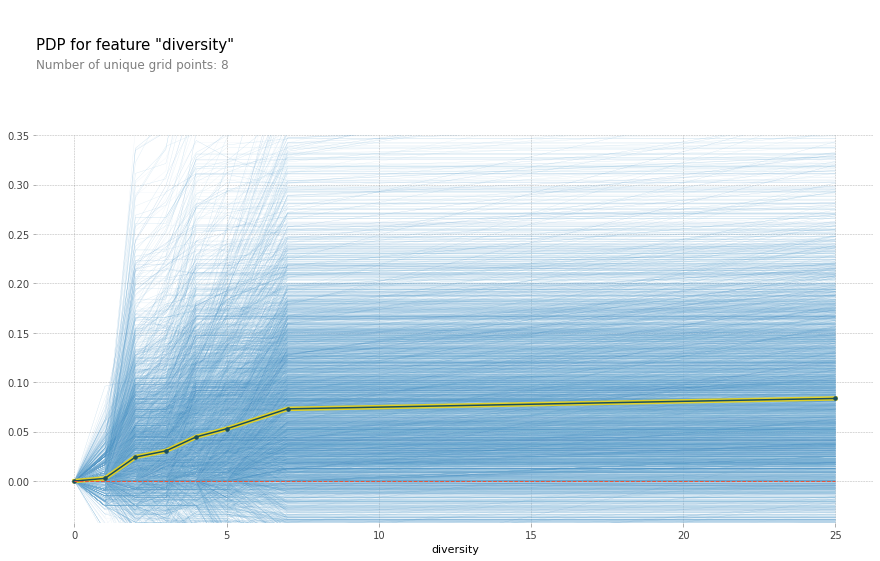

In [156]:
plot_pdp('diversity')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc884d0b38>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc8b8471d0>})

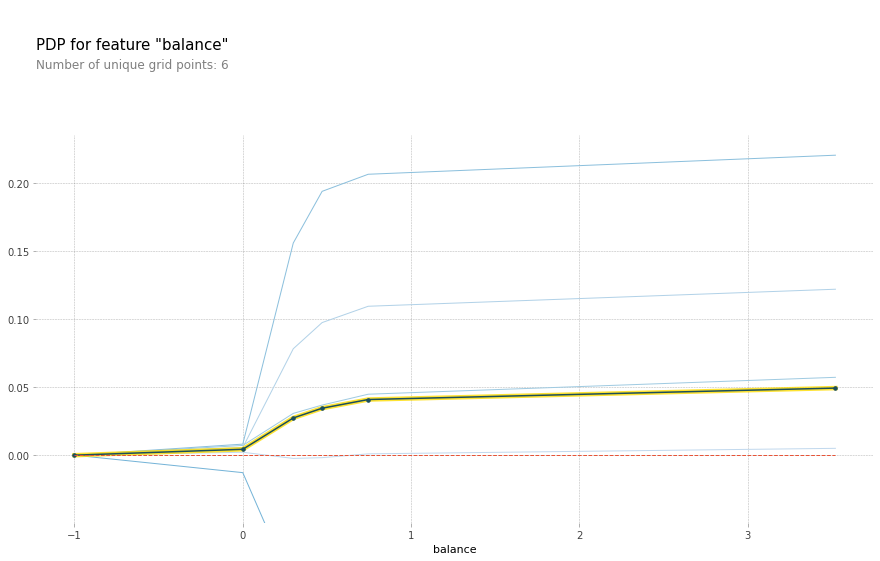

In [159]:
plot_pdp('balance', clusters=5)

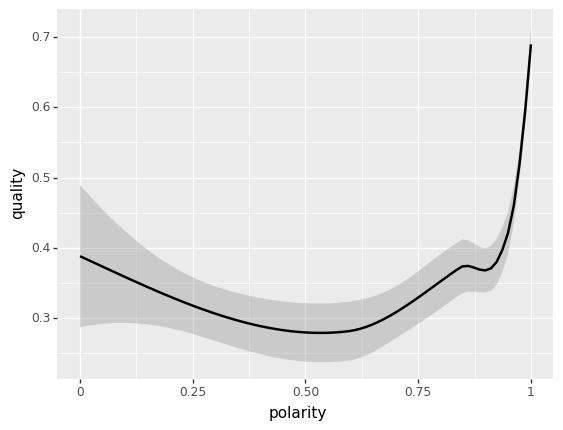

<ggplot: (8782277296918)>

In [160]:
ggplot(x_all, aes('polarity', 'quality')) + stat_smooth(se=True, method='loess')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc8df7bba8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc8b7547b8>})

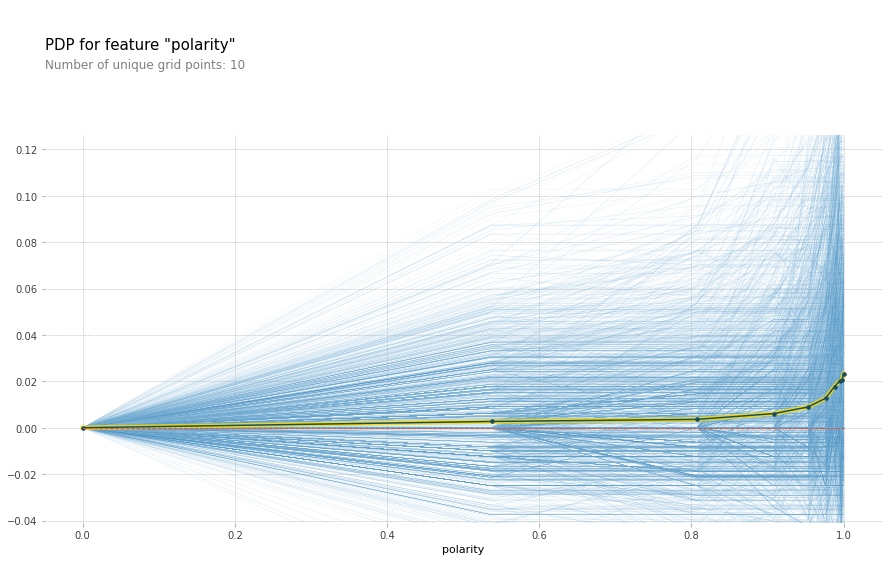

In [161]:
plot_pdp('polarity')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc84a4ce48>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc849fe4a8>})

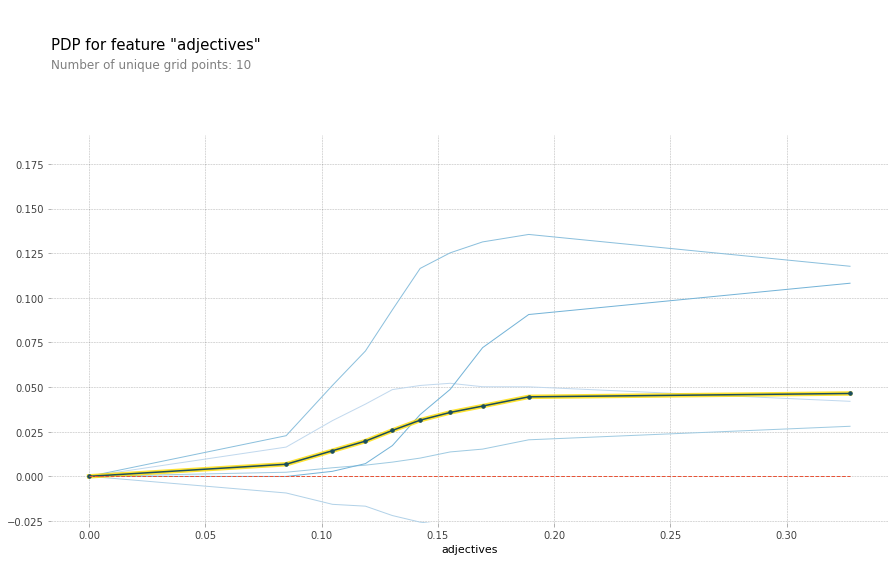

In [164]:
plot_pdp('adjectives', clusters=5)

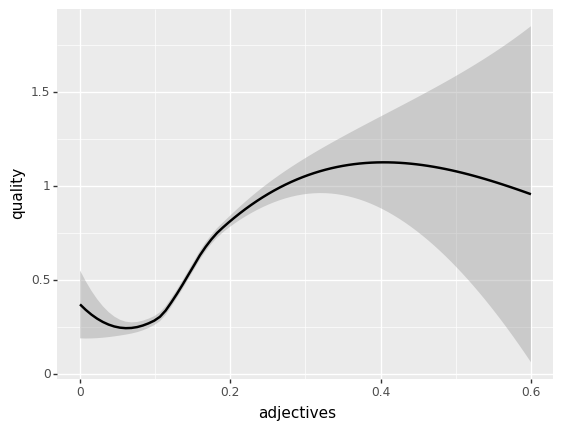

<ggplot: (-9223363254578066295)>

In [165]:
ggplot(x_all, aes('adjectives', 'quality')) + stat_smooth(se=True, method='loess')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc87c437f0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc86c01dd8>})

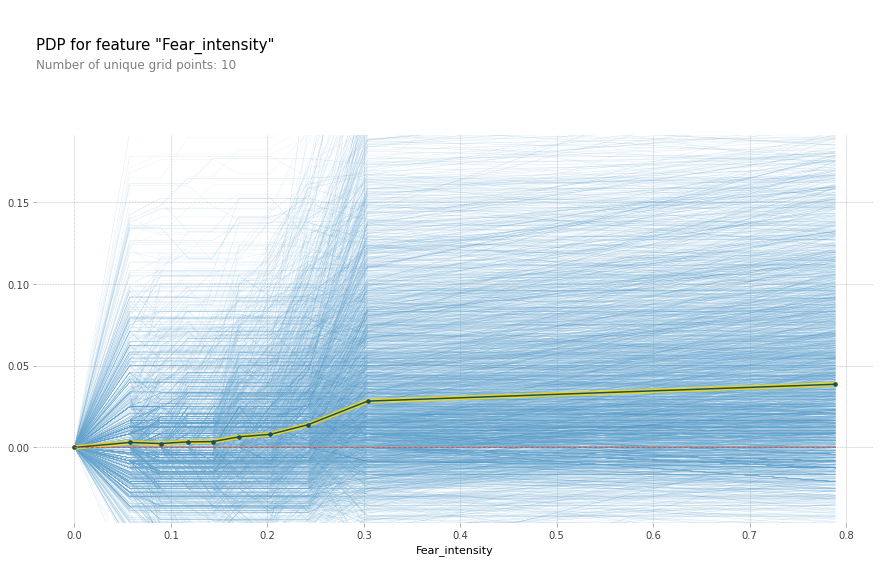

In [168]:
plot_pdp('Fear_intensity')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc7f760f60>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcc7f3e0198>})

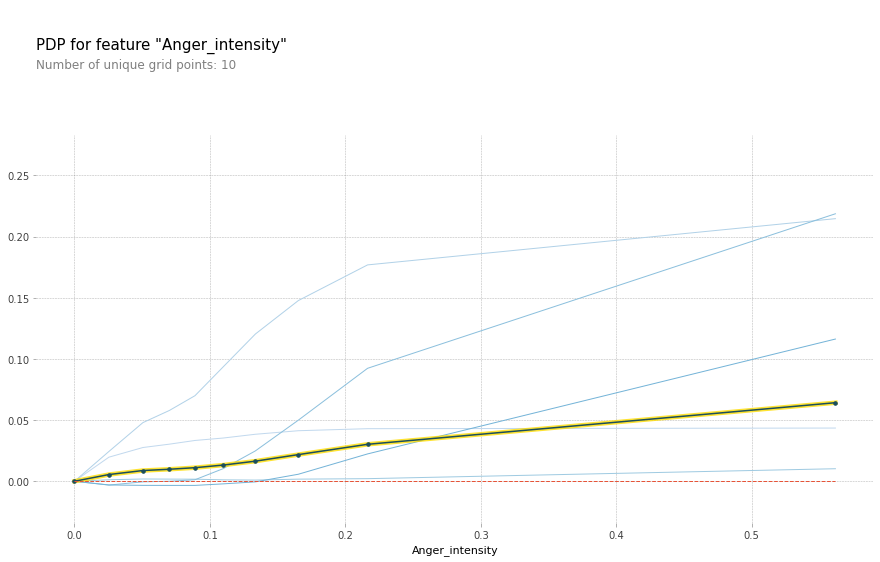

In [169]:
plot_pdp('Anger_intensity', clusters=5)

This needs a change at matplotlib files, but I have already tries dependecny plots and no features are co-dependent. 
https://forums.fast.ai/t/pbpbox-error-on-pdp-interact-plot/28468/8

In [170]:
#feats = ['Following', 'Followed By']
#p = pdp.pdp_interact(m, x, features = feats, model_features=x.columns)
#pdp.pdp_interact_plot(p, feats)

# Tree interpreter

In [94]:
from treeinterpreter import treeinterpreter as ti

In [95]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [96]:
row = X_valid.values[None,0]; row

array([[3.90000000e+01, 5.42068182e-01, 5.27863777e+00, 2.00000000e+00,
        0.00000000e+00, 4.00000000e+00, 6.45000000e+02, 7.22222222e+00,
        8.88888889e+00, 5.60013636e-01, 5.40129032e-01, 5.58139535e-01,
        4.52681818e-01, 3.05555556e+00, 1.00000000e+00, 4.18604651e+02,
        5.00000000e+00]])

In [97]:
prediction, bias, contributions = ti.predict(m, row)

In [98]:
prediction[0], bias[0]

(array([0.17365871, 0.82634129]), array([0.50005123, 0.49994877]))

In [99]:
[o for o in zip(df_keep.columns, df_valid.iloc[0], contributions[0])]

[('Difficulty', 39.0, array([-0.29877431,  0.29877431])),
 ('Dominance', 0.5420681818181822, array([ 0.13205142, -0.13205142])),
 ('Sentence length', 5.2786377708978325, array([-0.04271764,  0.04271764])),
 ('No Celebs', 2.0, array([-0.04694247,  0.04694247])),
 ('Title Polarity', 0.0, array([-0.04895019,  0.04895019])),
 ('Diversity', 4.0, array([-0.01632803,  0.01632803])),
 ('Length', 645.0, array([-0.03738426,  0.03738426])),
 ('Inspired', 7.222222222222222, array([-0.0141038,  0.0141038])),
 ('Fear', 8.888888888888891, array([ 0.0224753, -0.0224753])),
 ('Valence', 0.5600136363636363, array([-0.01149963,  0.01149963])),
 ('msttr', 0.5401290322580647, array([ 0.00407503, -0.00407503])),
 ('perc_uniq', 0.5581395348837209, array([ 0.04365293, -0.04365293])),
 ('Arousal', 0.4526818181818181, array([-0.02065612,  0.02065612])),
 ('Joy', 3.055555555555556, array([-0.01212734,  0.01212734])),
 ('Mistakes', 1.0, array([ 0.00479032, -0.00479032])),
 ('first_person', 418.60465116279073, arr

In [100]:
contributions[0].sum()

-8.673617379884035e-17

 waterfall chart https://github.com/chrispaulca/waterfall


import waterfall_chart
ti_plot = waterfall_chart.plot(X_valid.columns.values,contributions[0], rotation_value=90, threshold=0.1,formatting='{:,.3f}')
plt.ylabel('Change on y')

In [436]:
#! pip3 install waterfallcharts

#! curl https://bootstrap.pypa.io/get-pip.py | python     #auto katalathos to ekana!

# Extrapolation

In [253]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [254]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.7596561604584527

In [255]:
fi = rf_feat_importance(m, x); fi[:10]

cols       imp
14          adpositions  0.061701
18              valence  0.061170
20           adjectives  0.059225
6             particles  0.058702
13   noun_to_verb_ratio  0.058692
17          determiners  0.058622
8   strong_subjectivity  0.057385
7     lexical_diversity  0.057254
12          body_length  0.057169
3        Overperforming  0.056803